In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

from DE_analysis_utils import *

In [3]:
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 150  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 150

In [4]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_final'

In [5]:
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

base_mean_df = sc.get.obs_df(adata_de, adata_de.var_names.tolist() + ['culture_condition', 'chunk'], layer='baseMean')
base_mean_df = base_mean_df.drop_duplicates().sort_values('culture_condition')

base_mean_rest = base_mean_df[base_mean_df['culture_condition'] == 'Rest'].set_index('chunk').drop('culture_condition', axis=1).T
base_mean_stim = base_mean_df[base_mean_df['culture_condition'] == 'Stim8hr'].set_index('chunk').drop('culture_condition', axis=1).T
base_mean_stim48 = base_mean_df[base_mean_df['culture_condition'] == 'Stim48hr'].set_index('chunk').drop('culture_condition', axis=1).T

In [6]:
adata_de.var['mean_baseMean_Rest'] = base_mean_rest.mean(1).fillna(0)
adata_de.var['std_baseMean_Rest'] = base_mean_rest.std(1).fillna(10000)

adata_de.var['mean_baseMean_Stim8hr'] = base_mean_stim.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim8hr'] = base_mean_stim.std(1).fillna(10000)

adata_de.var['mean_baseMean_Stim48hr'] = base_mean_stim48.mean(1).fillna(0)
adata_de.var['std_baseMean_Stim48hr'] = base_mean_stim48.std(1).fillna(10000)

In [7]:
# Exclude from analysis genes with very low base mean across conditions
gs_mask = (adata_de.var['mean_baseMean_Stim8hr'] > 0.1) & (adata_de.var['mean_baseMean_Stim48hr'] > 0.1) & (adata_de.var['mean_baseMean_Rest'] > 0.1) 
adata_de = adata_de[:, gs_mask].copy()

In [8]:
DE_results = get_DE_results_long(
        adata_de,
        targets=['GATA3'], 
        effect_estimates = ['log_fc', 'lfcSE'],
        signif_estimate = 'adj_p_value',
        target_id_col = 'target_contrast_gene_name',
        gene_id_col='gene_ids'
    )

In [9]:
def get_reliability(x, sigma):
    sigma2_obs = np.var(x, ddof=1)  # Observed variance across features
    sigma2_sem = np.mean(sigma**2)   # Average squared standard error
    sigma2_true = sigma2_obs - sigma2_sem  # Estimated true signal variance
    reliability = sigma2_true / (sigma2_true + sigma2_sem)
    return(reliability)

def get_max_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    rel_a = get_reliability(x_a, sigma_a)
    rel_b = get_reliability(x_b, sigma_b)
    return np.sqrt(rel_a * rel_b)


In [10]:
DE_results_1 = DE_results[DE_results['culture_condition'] == 'Rest'].set_index('gene')[['log_fc', 'lfcSE', 'adj_p_value']].dropna()
DE_results_2 = DE_results[DE_results['culture_condition'] == 'Stim8hr'].set_index('gene')[['log_fc', 'lfcSE', 'adj_p_value']].dropna()

# Filter for significant effects first
DE_results_1 = DE_results_1[DE_results_1['adj_p_value'] < 0.1]
DE_results_2 = DE_results_2[DE_results_2['adj_p_value'] < 0.1]

# Get common significant genes
common_genes = DE_results_1.index.intersection(DE_results_2.index)
DE_results_1 = DE_results_1.loc[common_genes]
DE_results_2 = DE_results_2.loc[common_genes]

# DE_results_1['lfcSE'] = 0.6
rel_1 = get_reliability(DE_results_1['log_fc'], DE_results_1['lfcSE'])
# DE_results_2['lfcSE'] = 0.6
rel_2 = get_reliability(DE_results_2['log_fc'], DE_results_2['lfcSE'])
np.sqrt(rel_1 * rel_2)

0.9345336448809375

In [12]:
DE_results_1['lfcSE'] = 0.3
get_reliability(DE_results_1['log_fc'], DE_results_1['lfcSE'])

0.8861581968122989

In [100]:
scipy.stats.pearsonr(DE_results_2['log_fc'],DE_results_1['log_fc'])

PearsonRResult(statistic=0.8831186640075291, pvalue=6.728069971932097e-105)

0.9199269467229964

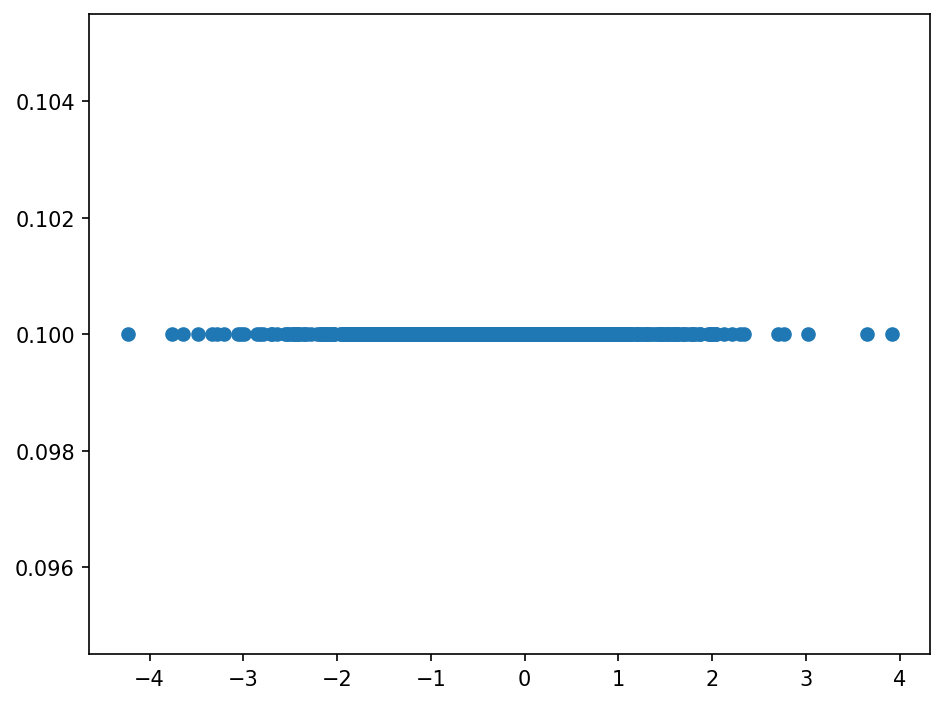

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# def extract_epsilon_ac(error_a, error_b):
#     """
#     Extract the correlated error component ε_ac using PCA
    
#     In Saccenti's model:
#     X = x_true + ε_ac + ε_au_x  
#     Y = y_true + ε_ac + ε_au_y
    
#     Given the observed errors for a and b, extract ε_ac (the shared component)
    
#     Parameters:
#     -----------
#     error_a, error_b : array-like
#         Observed errors for variables a and b (same length = number of samples)
#         These could be: measurement_a - true_value_a, measurement_b - true_value_b
        
#     Returns:
#     --------
#     epsilon_ac : array
#         Estimated correlated error component (same length as input)
#     """
#     error_a = np.array(error_a)
#     error_b = np.array(error_b)
#     error_matrix = np.column_stack([error_a, error_b])
    
#     # Apply PCA - the first PC captures the shared (correlated) component
#     pca = PCA(n_components=1)
#     epsilon_ac = pca.fit_transform(error_matrix).flatten()
#     return epsilon_ac


def estimate_sigma2_components(error_a, error_b):
    """
    Estimate all variance components for Saccenti Equation 12
    
    From Saccenti et al., Equation 12:
    σ²_x = σ²_x₀ + σ²_εₓₐᵤ + σ²_εₐc
    
    Where:
    - σ²_x₀ : true biological variance  
    - σ²_εₓₐᵤ : uncorrelated error variance for x
    - σ²_εₐc : correlated error variance
    
    Parameters:
    -----------
    error_a, error_b : array-like
        Observed errors for variables a and b
        
    Returns:
    --------
    dict with estimated variance components:
    - 'sigma2_eps_ac': correlated error variance σ²_εₐc
    - 'sigma2_eps_au_a': uncorrelated error variance for a σ²_εₐₐᵤ  
    - 'sigma2_eps_au_b': uncorrelated error variance for b σ²_εᵦₐᵤ
    - 'epsilon_ac': extracted correlated error component (vector)
    - 'epsilon_au_a': extracted uncorrelated error for a (vector)
    - 'epsilon_au_b': extracted uncorrelated error for b (vector)
    """
    
    # Convert to numpy arrays
    error_a = np.array(error_a)
    error_b = np.array(error_b)
    
    # Extract correlated and uncorrelated components of errors using PCA
    error_matrix = np.column_stack([error_a, error_b])
    pca = PCA()
    transformed = pca.fit_transform(error_matrix)
    
    # Get the full decomposition
    epsilon_ac_full = transformed[:, 0]  # PC1 scores (correlated component)
    epsilon_residual = transformed[:, 1]  # PC2 scores (uncorrelated differences)
    
    # Get loadings to reconstruct original errors
    pc1_loadings = pca.components_[0]  # Loadings for PC1
    pc2_loadings = pca.components_[1]  # Loadings for PC2
    
    # The uncorrelated error for each variable is the PC2 contribution
    epsilon_au_a = pc2_loadings[0] * epsilon_residual
    epsilon_au_b = pc2_loadings[1] * epsilon_residual
    
    # Step 3: Estimate variance components
    sigma2_eps_ac = np.var(epsilon_ac_full)          # Correlated error variance
    sigma2_eps_au_a = np.var(epsilon_au_a)           # Uncorrelated error variance for a
    sigma2_eps_au_b = np.var(epsilon_au_b)           # Uncorrelated error variance for b
    
    return {
        'sigma2_eps_ac': sigma2_eps_ac,
        'sigma2_eps_au_a': sigma2_eps_au_a, 
        'sigma2_eps_au_b': sigma2_eps_au_b,
        'epsilon_ac': epsilon_ac_full,
        'epsilon_au_a': epsilon_au_a,
        'epsilon_au_b': epsilon_au_b
    }


def compute_attenuated_correlation(x_a, x_b, error_a, error_b):
    """
    Compute the attenuated (observed) correlation between x_a and x_b 
    and provide components for Saccenti's correction
    
    From Saccenti et al., the observed correlation is affected by measurement errors.
    This function computes the observed correlation and estimates all components
    needed for attenuation correction.
    
    Parameters:
    -----------
    x_a, x_b : array-like
        Observed measurements for variables a and b
    error_a, error_b : array-like
        Known errors for the measurements
        
    Returns:
    --------
    dict with correlation and error components:
    - 'r_observed': observed (attenuated) correlation
    - 'sigma2_x_a': total variance of x_a  
    - 'sigma2_x_b': total variance of x_b
    - 'sigma2_eps_ac': correlated error variance
    - 'sigma2_eps_au_a': uncorrelated error variance for a
    - 'sigma2_eps_au_b': uncorrelated error variance for b
    - 'gamma_a_au': uncorrelated error ratio for a (σ²_εₐₐᵤ / σ²_x₀_a)
    - 'gamma_b_au': uncorrelated error ratio for b (σ²_εᵦₐᵤ / σ²_x₀_b) 
    - 'gamma_a_ac': correlated error ratio for a (σ²_εₐc / σ²_x₀_a)
    - 'gamma_b_ac': correlated error ratio for b (σ²_εₐc / σ²_x₀_b)
    - 'A_a': attenuation coefficient from Eq. 32
    """
    
    # Convert to numpy arrays
    x_a = np.array(x_a)
    x_b = np.array(x_b)
    
    # Compute observed correlation
    r_observed = np.corrcoef(x_a, x_b)[0, 1]
    
    # Estimate error variance components
    error_components = estimate_sigma2_components(error_a, error_b)
    
    # True biological variances (total variance - error variances)
    # From Eq. 12: σ²_x = σ²_x₀ + σ²_εₐᵤ + σ²_εₐc
    sigma2_x0_a = np.var(x_a) - error_components['sigma2_eps_au_a'] - error_components['sigma2_eps_ac']
    sigma2_x0_b = np.var(x_b) - error_components['sigma2_eps_au_b'] - error_components['sigma2_eps_ac']
    
    # Ensure biological variances are positive
    sigma2_x0_a = max(sigma2_x0_a, 1e-10)
    sigma2_x0_b = max(sigma2_x0_b, 1e-10)
    
    # Calculate error ratios (gamma parameters from Eq. 32)
    gamma_a_au = error_components['sigma2_eps_au_a'] / sigma2_x0_a
    gamma_b_au = error_components['sigma2_eps_au_b'] / sigma2_x0_b
    gamma_a_ac = error_components['sigma2_eps_ac'] / sigma2_x0_a  
    gamma_b_ac = error_components['sigma2_eps_ac'] / sigma2_x0_b
    
    # Attenuation coefficient (Eq. 32)
    A_a = 1 / np.sqrt((1 + gamma_a_au + gamma_a_ac) * (1 + gamma_b_au + gamma_b_ac))
    
    return {
        'r_observed': r_observed,
        'sigma2_x0_a': sigma2_x0_a,
        'sigma2_x0_b': sigma2_x0_b,
        'sigma2_eps_ac': error_components['sigma2_eps_ac'],
        'sigma2_eps_au_a': error_components['sigma2_eps_au_a'],
        'sigma2_eps_au_b': error_components['sigma2_eps_au_b'],
        'gamma_a_au': gamma_a_au,
        'gamma_b_au': gamma_b_au,
        'gamma_a_ac': gamma_a_ac,
        'gamma_b_ac': gamma_b_ac,
        'A_a': A_a
    }


def apply_saccenti_correction(correlation_results, sign_correlated_error='+'):
    """
    Apply Saccenti's attenuation correction (Eq. 33)
    
    Parameters:
    -----------
    correlation_results : dict
        Results from compute_attenuated_correlation()
    sign_correlated_error : str
        '+' for positively correlated error, '-' for negatively correlated error
        
    Returns:
    --------
    r_corrected : float
        Attenuation-corrected correlation
    """
    
    # Extract components
    r_obs = correlation_results['r_observed']
    gamma_a_ac = correlation_results['gamma_a_ac'] 
    gamma_b_ac = correlation_results['gamma_b_ac']
    A_a = correlation_results['A_a']
    
    # Correction term (Eq. 33)
    correction_term = (gamma_a_ac * gamma_b_ac) / np.sqrt(
        (1 + correlation_results['gamma_a_au'] + gamma_a_ac) * 
        (1 + correlation_results['gamma_b_au'] + gamma_b_ac)
    )
    
    # Apply sign for correlated error
    if sign_correlated_error == '+':
        r_corrected = (r_obs - correction_term) / A_a
    else:  # negative correlation
        r_corrected = (r_obs + correction_term) / A_a
        
    return r_corrected

In [ ]:
error_a = np.array(error_a)
error_b = np.array(error_b)

# Extract correlated and uncorrelated components of errors using PCA
error_matrix = np.column_stack([error_a, error_b])
pca = PCA()
transformed = pca.fit_transform(error_matrix)

array([[-0.43173937,  0.07894771],
       [-0.16741984,  0.23183607],
       [-0.25547894, -0.0588922 ],
       ...,
       [ 0.10395583, -0.00187289],
       [-0.02965973, -0.14650666],
       [ 0.11644856,  0.18073937]])

In [33]:
def get_theoretical_max_correlation(correlation_results):
   """
   Compute theoretical maximum observable correlation 
   assuming true variables are identical (r_true = 1.0)
   
   Parameters:
   -----------
   correlation_results : dict
       Results from compute_attenuated_correlation()
   
   Returns:
   --------
   r_max : float
       Theoretical maximum observable correlation
   """
   
   # Extract variance components
   sigma2_x0_a = correlation_results['sigma2_x0_a']
   sigma2_x0_b = correlation_results['sigma2_x0_b'] 
   sigma2_eps_ac = correlation_results['sigma2_eps_ac']
   sigma2_eps_au_a = correlation_results['sigma2_eps_au_a']
   sigma2_eps_au_b = correlation_results['sigma2_eps_au_b']
   
   # Assume biological signals have same variance for max correlation case
   sigma2_true = np.sqrt(sigma2_x0_a * sigma2_x0_b)  # geometric mean
   
   # Numerator: shared variance (true signal + correlated error)
   shared_variance = sigma2_true + sigma2_eps_ac
   
   # Denominators: total variance for each variable
   total_var_a = sigma2_true + sigma2_eps_ac + sigma2_eps_au_a
   total_var_b = sigma2_true + sigma2_eps_ac + sigma2_eps_au_b
   
   # Maximum theoretical correlation
   r_max = shared_variance / np.sqrt(total_var_a * total_var_b)
   
   return r_max

In [26]:
DE_results[DE_results['culture_condition'] == 'Rest'].set_index('gene')

,index,log_fc,lfcSE,adj_p_value,significant,gene_ids,culture_condition,target_contrast,target_contrast_gene_name
gene,,,,,,,,,
ENSG00000000419,ENSG00000107485_Rest,0.011432,0.064086,0.954677,False,ENSG00000000419,Rest,ENSG00000107485,GATA3
ENSG00000000457,ENSG00000107485_Rest,0.111320,0.094025,0.597125,False,ENSG00000000457,Rest,ENSG00000107485,GATA3
ENSG00000000460,ENSG00000107485_Rest,0.068980,0.112771,0.820330,False,ENSG00000000460,Rest,ENSG00000107485,GATA3
ENSG00000000971,ENSG00000107485_Rest,-1.065160,0.865268,0.574805,False,ENSG00000000971,Rest,ENSG00000107485,GATA3
ENSG00000001036,ENSG00000107485_Rest,-0.099610,0.167446,0.825015,False,ENSG00000001036,Rest,ENSG00000107485,GATA3
...,...,...,...,...,...,...,...,...,...
ENSG00000284770,ENSG00000107485_Rest,0.249763,0.082190,0.040743,True,ENSG00000284770,Rest,ENSG00000107485,GATA3
ENSG00000285077,ENSG00000107485_Rest,0.021982,0.117063,0.952473,False,ENSG00000285077,Rest,ENSG00000107485,GATA3
ENSG00000288722,ENSG00000107485_Rest,0.199963,0.449061,0.875155,False,ENSG00000288722,Rest,ENSG00000107485,GATA3


In [87]:
# Get DE results for each condition
DE_results_1 = DE_results[DE_results['culture_condition'] == 'Rest'].set_index('gene')[['log_fc', 'lfcSE', 'adj_p_value']].dropna()
DE_results_2 = DE_results[DE_results['culture_condition'] == 'Stim8hr'].set_index('gene')[['log_fc', 'lfcSE', 'adj_p_value']].dropna()

# Find common genes between conditions
common_genes = DE_results_1.index.intersection(DE_results_2.index)

# Filter for common genes
DE_results_1 = DE_results_1.loc[common_genes]
DE_results_2 = DE_results_2.loc[common_genes]

eps_a = DE_results_1['lfcSE']
eps_b = DE_results_2['lfcSE']
cor_res = compute_attenuated_correlation(DE_results_1['log_fc'],DE_results_2['log_fc'], DE_results_1['lfcSE'],DE_results_2['lfcSE'])
# saccenti_max = get_theoretical_max_correlation(cor_res)
apply_saccenti_correction(cor_res)
cor_res

{'r_observed': 0.4905323320356689,
 'sigma2_x_a': 0.12007352786760024,
 'sigma2_x_b': 0.11693246622273247,
 'sigma2_x0_a': 0.0728532779571309,
 'sigma2_x0_b': 0.06913549059244076,
 'sigma2_eps_ac': 0.0457238071168837,
 'sigma2_eps_au_a': 0.0014964427935856438,
 'sigma2_eps_au_b': 0.002073168513408014,
 'gamma_a_au': 0.020540500517577213,
 'gamma_b_au': 0.029987036985526117,
 'gamma_a_ac': 0.6276149598071482,
 'gamma_b_ac': 0.6613651935505773,
 'A_a': 0.5989407787690507}

In [ ]:
(DE_results_1['lfcSE'],DE_results_2['lfcSE'])

PearsonRResult(statistic=0.8521060854138738, pvalue=0.0)

In [44]:
cor_res['r_observed'] 
# / get_max_correlation(DE_results_1['log_fc'], DE_results_1['lfcSE'], DE_results_2['log_fc'],DE_results_2['lfcSE'])

0.4905323320356689

In [82]:
# Simulate complete data following Saccenti's model
np.random.seed(42)
n_samples = 10000

# True biological correlation and signals
true_r_biological = 0.6
true_x0_a = np.random.normal(0, 1, n_samples)
true_x0_b = true_r_biological * true_x0_a + np.random.normal(0, np.sqrt(1 - true_r_biological**2), n_samples)

# True error variance components 
true_sigma2_eps_ac = 0.1**2     
true_sigma2_eps_au_a = 0.24**2    
true_sigma2_eps_au_b = 0.15**2   

# Generate error components
true_epsilon_ac = np.random.normal(0, np.sqrt(true_sigma2_eps_ac), n_samples)
true_epsilon_au_a = np.random.normal(0, np.sqrt(true_sigma2_eps_au_a), n_samples)
true_epsilon_au_b = np.random.normal(0, np.sqrt(true_sigma2_eps_au_b), n_samples)

# Construct observed measurements (Saccenti's model)
x_a_observed = true_x0_a + true_epsilon_ac + true_epsilon_au_a
x_b_observed = true_x0_b + true_epsilon_ac + true_epsilon_au_b

# Known errors (in practice these might come from technical replicates, etc.)
error_a = true_epsilon_ac + true_epsilon_au_a  
error_b = true_epsilon_ac + true_epsilon_au_b

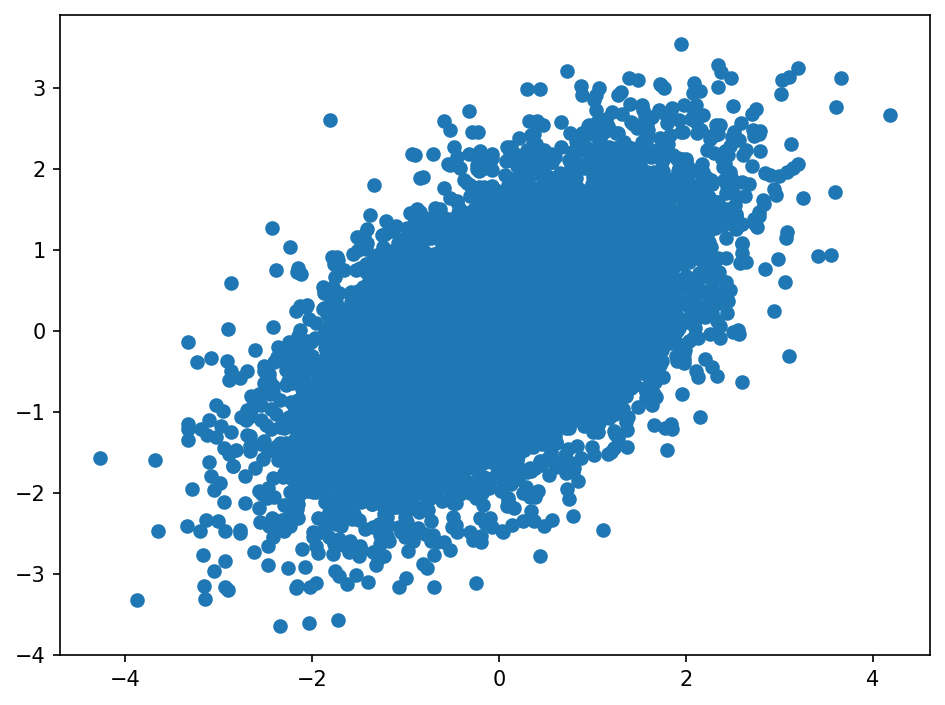

In [83]:
plt.scatter(x_a_observed, x_b_observed)

In [86]:
cor_res = compute_attenuated_correlation(x_a_observed, x_b_observed, error_a, error_b)
apply_saccenti_correction(cor_res)
# get_theoretical_max_correlation(cor_res)

0.6284317468328129

In [85]:
get_max_correlation(x_a_observed, error_a, x_b_observed, error_b)

0.952464352760896

Alternatives 
- Bi-variate MASH like in the TRADE paper (https://www.nature.com/articles/s41588-025-02169-3#Sec1): not really an alternative, it allows to compare correlations even when the ceiling is pretty different 

How do we know if this tends to over-estimate similarities? 
- Show that you can have same log FC correlation with very different ceiling - a model could have high performance in logFC prediction task for high correlation on perturbations with large errors, another could do better on perturbations with low errors, but very close to theoretical ceiling.  

Solutions:
- distance from ceiling (percentage?), assuming the standard error in the predicted logFC is the same 
- should we consider the standard errors of the predicted log fold changes? 
- Is better prediction on perturbations with high reliability more desirable? Than on perturbations with lower reliability?

This matters especially in comparisons between cell types, where the noise levels are very different (entirely driven by base mean expression)